### Entities & Aspect Mining : An example

This mini workshop will illustrate two tasks. The first is to illustrate the extraction of triples relationships. This is done considering only simple CFG. It is similar to what it done in Open Calais in https://permid.org/onecalaisViewer, and is very useful in extracting granular information from a document. The second is the extraction of 'sentiment-related' words on the aspects to generate their aspects scores through a heuristic method. 


In [1]:
# Import packages
import spacy
import numpy as np
from spacy import displacy
import pickle as pk
from os import getcwd
import pandas as pd
import json

import cufflinks  # for visualisation
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

ModuleNotFoundError: No module named 'cufflinks'

## First Task : extraction of triples dependencies

The reviews are extracted from Yelp for a Chinese restaurant which was previously scrapped from their website (only 20 of them for illustration).

In [2]:
df_reviews = pd.read_csv('data\Reviews_DTF.txt', sep = '\t', names=["reviews"])
df_reviews.head(3)
len(df_reviews)
df_reviews

,reviews
0,I love this place. I visit this place (or one ...
1,"Must try: xiao long bao, chili crab bun, fried..."
2,Highly recommend trying the chili sauce also. ...
3,For those who are not familiar with asian food...
4,This Din Tai Fung is located on the 4th floor ...
5,The staff at the entrance gave me a number and...
6,Staffs were all friendly and attentive. I like...
7,FOOD 4/5 The legendary xiao long bao (steamed ...
8,AMBIENCE 3/5 It was noisy but I did not expect...
9,"STAFFS 5/5 Staffs were attentive, helpful and ..."


As learnt from the lectures, the aspects need to be categorised and 'targeted' with the frequency approach. We list down some of the more often used phrases associate with each aspect. This is in a way a heuristic method.

In [4]:
nlp = spacy.load('en_core_web_sm')
eg=5
print (df_reviews["reviews"][eg])
print ("----------")
doc = nlp(df_reviews["reviews"][eg])  # 2nd review
for sent in doc.sents:
    print ("------")
    for token in sent:
        print(token.text, token.dep_, token.head.text, token.head.pos_,
              [child for child in token.children])


The staff at the entrance gave me a number and a paper & pen so I could check what I liked to order while waiting. The wait was not bad at all. Good thing I did not have to stand in line. Think I ever mentioned in my other post, I do not like to stand in line, period! 
----------
------
The det staff NOUN []
staff nsubj gave VERB [The, at]
at prep staff NOUN [entrance]
the det entrance NOUN []
entrance pobj at ADP [the]
gave ROOT gave VERB [staff, me, number, check, .]
me dative gave VERB []
a det number NOUN []
number dobj gave VERB [a, and, paper]
and cc number NOUN []
a det paper NOUN []
paper conj number NOUN [a, &, pen]
& cc paper NOUN []
pen conj paper NOUN []
so mark check VERB []
I nsubj check VERB []
could aux check VERB []
check advcl gave VERB [so, I, could, liked, waiting]
what dobj liked VERB []
I nsubj liked VERB []
liked ccomp check VERB [what, I, order]
to aux order NOUN []
order xcomp liked VERB [to]
while mark waiting VERB []
waiting advcl check VERB [while]
. punct g

In [13]:
# this is similar to the earlier workshop in Day 1.
displacy.render(sent, style='dep', jupyter=True, options = { 'distance':80 })

Observe the rendered dependency tree. 
Question : How many sentences are there in the review? An often assumption is in one sentence, there is one target and one entity. Let's break up the sentences and examine the breakdown. 

In [5]:
sentt = []
for idno, sentence in enumerate(doc.sents):
    print ('Sentence {}:'.format(idno + 1), sentence)
    sentt.append(sentence)

Sentence 1: The staff at the entrance gave me a number and a paper & pen so I could check what I liked to order while waiting.
Sentence 2: The wait was not bad at all.
Sentence 3: Good thing I did not have to stand in line.
Sentence 4: Think I ever mentioned in my other post, I do not like to stand in line, period!


Let's look at the breakdown of the first sentence in detail. In this sentence, where is the root of the sentence, where everything is joined together? However, it is possible that sometimes due to the sentence structure it is open there is no root.

In [6]:
def getRoot(sentence):
    depy=[]
    print ("Input sentence is: " + str(sentence))
    for tok in sentence:
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        print (dep)
        depy.append(dep)
    root = list(filter(lambda x : x[1]=="ROOT" or x[1].find("comp")!=-1, depy))
    #root = list(filter(lambda x : x[1]=="VP", depy))
    if len(root) == 0 : return 999
    return root
  #  print (possible_subject, possible_subject.dep_, possible_subject.head.pos_)
  #  if possible_subject.dep == "nsubj" and possible_subject.head.pos == "VERB":
  #      verbs.add(possible_subject.head)

sentence = "John likes an apple"
#sentence = "The apple tastes delicious."
root = getRoot(nlp(sentence))
print ("The root or compis :" + str(root))

Input sentence is: John likes an apple
('John', 'nsubj', '---> ', 'likes')
('likes', 'ROOT', '---> ', 'likes')
('an', 'det', '---> ', 'apple')
('apple', 'dobj', '---> ', 'likes')
The root or compis :[('likes', 'ROOT', '---> ', 'likes')]


We are now ready to extract 'triples' relationships as studied in class. The predicate can come from the root or component clauses without its own object/subject. The subject could be the first 'nsubj', and the object will come after as the 'acomp', 'dobj' etc. Putting it altogether, and do on a simple example.

In [7]:
def getTriples(root, sentence):
    depy=[]
    #print (root)
    for tok in sentence:  # tokenize it again
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        depy.append(dep)
    subj = list(filter(lambda x : x[1]=="nsubj", depy))
    #print (subj)
    #obj = list(filter(lambda x : x[1]=="dobj" or x[1]=="acomp", depy))  # uncomment this for new rule
    obj = list(filter(lambda x : x[1]=="dobj", depy))
    #root = list(filter(lambda x : x[1]=="ROOT" , depy))
    #print (obj)
    #print ("root is" + str(root))
    try: 
        triples = (subj[0][0], root[0][0], obj[0][0])
    except IndexError:
        print ("Grammar incorrect. No triples for " + str(sentence)) # rules needed to be written to extract some triples
        print ("Grammar is " + str(depy))
        return None
    return triples

triples=[]
doc = "John likes big apple. The apple tastes delicious."
#doing it sentence by sentence
for sentence in nlp(doc).sents:
    root = getRoot(sentence)  # obtain root of one sentence
    if root != 999 : 
        triple = getTriples(root, sentence)  # obtain triples in that sentence
        print ("Triple is " + str(triple))
   # triples.append(triple)


Input sentence is: John likes big apple.
('John', 'nsubj', '---> ', 'likes')
('likes', 'ROOT', '---> ', 'likes')
('big', 'amod', '---> ', 'apple')
('apple', 'dobj', '---> ', 'likes')
('.', 'punct', '---> ', 'likes')
Triple is ('John', 'likes', 'apple')
Input sentence is: The apple tastes delicious.
('The', 'det', '---> ', 'apple')
('apple', 'nsubj', '---> ', 'tastes')
('tastes', 'ROOT', '---> ', 'tastes')
('delicious', 'acomp', '---> ', 'tastes')
('.', 'punct', '---> ', 'tastes')
Grammar incorrect. No triples for The apple tastes delicious.
Grammar is [('The', 'det', '---> ', 'apple'), ('apple', 'nsubj', '---> ', 'tastes'), ('tastes', 'ROOT', '---> ', 'tastes'), ('delicious', 'acomp', '---> ', 'tastes'), ('.', 'punct', '---> ', 'tastes')]
Triple is None


This is a simple example of extraction triples which are relationships. We use context-free grammar and dependency relations studied in class to be able to form the relationships. We need to add more rules to other factors like noun chunks, compound objects, named entity recoginition to group together nouns for either subject/ object. Even broken grammar! Do you understand why NLP at a granular level is so difficult now? 

## Extraction of aspect and entities

As taught in class, the extraction of sentiment scores on entities is often done on a semi-supervised basis. We need to do a 'mapping function' on the subjects and objects. For the case of restaurants, the usual aspects are 'food', 'service' and 'price'. 

In [8]:
# entity & aspect categories
# From Frequency approach
aspect = {"food": ["xiao long bao", "noodles", "food", "dumplings", "pork", "flavour", "chili", 
                   "dishes", "lunch", "bun", "shrimp", "dimsum", "rice", "chicken"],
        "service" : ["staff", "wait", "water", "queue" ],
        "price" : ["price", "cost"]   }
# overall : will be everything else    
# Helper function for categorising aspects:
def aspectCat(sentence):
    category=[]
    for tok in sentence:
        tok = tok.text.lower()
        for key, val in aspect.items():
            if tok in val: category.append(key)
    if len(category) == 0 : category.append("overall")
    return category

In the next loop, the reviews are first read and dependency parsed, and then tokenized. The root words are identified in each sentence to parse the reviews. Each of the root is assumed to refer to a certain aspect. (We will discuss more about this later.)
On parsing, a sentiment classification is run on the individual components and its aspect categorised depending on if the words belong to a category of words.

In [10]:
reviews_sent =[] 
# reloading vectoriser & svm classifier
output_dir = "models\\my_nlp_sm"
my_nlp = spacy.load(output_dir)

sent_map = {"positive":1, "neutral":0, "negative":-1}

def getSentiment(span):
    res = my_nlp(span.text)
    
    # map score from positive -> +1; negative -> -1; neutral -> 0
    senti = np.round(sum([sent_map[items[0]]*items[1] for items in res.cats.items()]),2)
    
    #print(res, senti)
    #print("-------------")
    return (res,senti)

ex=4
doc = nlp(df_reviews["reviews"][ex])
for idx, sentence in enumerate(doc.sents):
    #print (sentence)
    res = getSentiment(sentence)
    try:
        cat = aspectCat(sentence)      
        reviews_sent.append({"scores":list(res[0]), "text":sentence, "category":cat})
    except IndexError:
        # there are no specific aspects talked about. Just in general
        reviews_sent.append({"scores":list(res[0]), "text":sentence, "category":"overall"})


Let's do it for the whole set of reviews and do a summarisation. 

In [11]:
reviews = {}
for i in range(len(df_reviews["reviews"])):
    doc = nlp(df_reviews["reviews"][i])
    reviews_sent =[] 
    for idx, sentence in enumerate(doc.sents):
        #print (sentence)
        res = getSentiment(sentence)
        try:
            cat = aspectCat(sentence)      
            reviews_sent.append({"scores":res[1], "text":sentence.text, "category":cat})
        except IndexError:
            reviews_sent.append({"scores":res[1], "text":sentence.text, "category":"overall"})
    reviews[i]=reviews_sent

# summarise all reviews
summary_scores = {"overall":[], "service":[], "price":[], "food":[]}
# count total no of 
for item in reviews.items():
    for ResultList in item[1]:
        score = ResultList["scores"]
        for CatList in ResultList["category"]:
            summary_scores[CatList].append(score)

# Modifying summary_scores for each category
# print (summary_scores)
for key, val in summary_scores.items():
    #avg = round(np.mean(val),2)
    pos = np.sum(np.array(val) >= 0, axis=0)
    neg = np.sum(np.array(val) < 0, axis=0)
    summary_scores[key]={"pos":pos,"neg": neg, "buzz": pos + neg}
#summary_scores["total no of reviews"]=len(reviews)

df_summary = pd.DataFrame(summary_scores)
df_summary=df_summary.transpose()

In [20]:
df_summary  #buzz is the number of particular aspect

,buzz,neg,pos
overall,34,23,11
service,5,5,0
price,3,2,1
food,46,43,3


In [21]:
df_summary.columns=[ "buzz", "negative", "positive"]
df_summary["category"] = df_summary.index
df_summary["sentiment"] = np.round((df_summary["positive"]-df_summary["negative"])/(df_summary["negative"]+df_summary["positive"]),2)


In [22]:
df_summary = df_summary[["category","sentiment","buzz"]]
df_summary

,category,sentiment,buzz
overall,overall,-0.35,34
service,service,-1.00,5
price,price,-0.33,3
food,food,-0.87,46


Notice most of the time, the reviewers are talking mostly about the food quality. Finally the last step to present in a visualisation manner. This is most appropriate to present in a treemap. The implementation is however quite wieldy in Python. 

Text(0.5, 1.0, 'Sentiment Heat Map of Restaurant Aspects')

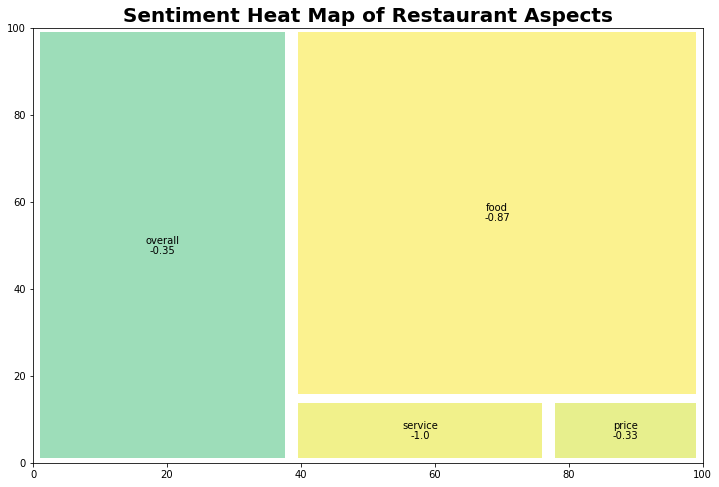

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify

norm = matplotlib.colors.Normalize(vmin=min(df_summary.sentiment), vmax=max(df_summary.sentiment))
#colors = [matplotlib.cm.Reds(norm(value)) for value in df_summary.sentiment]

fig = plt.gcf()
fig.set_size_inches(12, 8)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
#squarify.plot(label=df_summary.category,sizes=df_summary.buzz, color = colors, alpha=.5, pad =True)
# As an exercise, use a colormap intensity to reflect the sentiment value. 
squarify.plot(label=df_summary.category,sizes=df_summary.buzz, value = df_summary.sentiment,alpha=.5, pad =True)
plt.title("Sentiment Heat Map of Restaurant Aspects",fontsize=20,fontweight="bold")

### Conclusion
This example illustrates how the reviews are categorised and sentiment classified based on 3 aspect categories - food, price and service, with the rest as others.

There are many ways to improve on it. This includes using:
 - stemming to identify mapped words
 - integrating with consistency parsing to obtain noun chunks
 - Other ways to improve on it is to fine-tine the training set, like using negation etc and also using co-reference resolution. The latter is useful as many of the pronouns like 'it', 'they'  have no identified targets in the subsequent sentences. They should similarly be mapped to the relevant entities and aspects.

### Exercise

- Perform the same exercise on another set of data - this time for rows of the airline sentiment data in the previous exercise. What are the difficulties that you face? What aspects (and groups) do you consider in this case (heuristically)?